# Multiprocessing


In this lab you will learn a little about multiprocessing in python. For most of the lab we will be using the "multiprocess" package rather than multiprocessing. The python kernel interferes with the multiprocessing module.

## Thread

You can think of threads as a dumb, new program that by default knows nothing about the rest of our code. We can create this new worker using the "Process" function. We give the process a function to run and potentially arguments to that function.  We use the "start" function to tell the thread to begin and the "join" function when we want the thread to end.


In [90]:
# !pip install multiprocess

In [91]:
import multiprocess
import time 

def wait_arround():
    time.sleep(3)
    
process=multiprocess.Process(target=wait_arround,args=())
process.start()
starttime = time.time()
process.join()
print(time.time()-starttime)

3.010148048400879


In the following cell start three different threads, all doing different tasks and join them at the end. In addition use the args parameter. For example I could have passed in the number of seconds to sleep in the above example.

In [92]:
def wait_arround(t):
    time.sleep(t)

procs = []
# instantiating process with arguments
for i in range(4, 7): 
    proc=multiprocess.Process(target=wait_arround, args=(i,))
    procs.append(proc)
    proc.start()

# complete the processes
starttime = time.time()
for proc in procs:
    proc.join()

print(time.time()-starttime)

6.01194429397583


## Locks

Remember, each thread run completely independently.  This can cause problems. In the example below we are running three threads. Each thread is accessing the same file and updates it content by one.  Given that each thread is updating it by 1, the final result should be 3000. Run this cell several times and examine the result.


In [93]:
import multiprocess

fl=open("num.txt","w")
fl.write("0")
fl.close()

def process_function():
    for i in range(1000):
        fl=open("num.txt")
        v=int(fl.read().strip())+1
        fl.close()
        fl=open("num.txt","w")
        fl.write(str(v))
        fl.close()

process_1 = multiprocess.Process(target=process_function, args=())
process_2 = multiprocess.Process(target=process_function, args=())
process_3 = multiprocess.Process(target=process_function, args=())

process_1.start()
process_2.start()
process_3.start()
process_1.join()
process_2.join()
process_3.join()

fl=open("num.txt")
print(fl.read())

Process Process-154:
Traceback (most recent call last):
  File "/Users/haipeng/opt/miniconda3/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/haipeng/opt/miniconda3/lib/python3.9/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Process Process-156:
  File "/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_25067/3774967307.py", line 10, in process_function
    v=int(fl.read().strip())+1
ValueError: invalid literal for int() with base 10: ''
Traceback (most recent call last):
  File "/Users/haipeng/opt/miniconda3/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/haipeng/opt/miniconda3/lib/python3.9/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/pm/r13f8d0d1sj22_6qw9cpgz5h0000gn/T/ipykernel_25067/3774967307.py", line 10, in process_fun

1015


You likely saw an error when running the cell. What do you think is going on?

**Response**: Since multiple processes are used, conflicts occur when some process is writing the data while another process is trying to read the data.

The call multiprocess.Lock() return a lock object.  A process can ask to acquire a lock. Once it has acquired a lock it can proceed to the next line of the code. All other threads will pause until the can acquire the lock. Copy the code above into the next cell. Create a lock and then pass that lock object as an argument to the process_function. Figure out where to put the locks (inside the for loop) so you get the correct result.

In [94]:
import multiprocess

fl=open("num.txt","w")
fl.write("0")
fl.close()

def process_function(lock):
    for i in range(1000):
        with lock:
            fl=open("num.txt")
            v=int(fl.read().strip())+1
            fl.close()
            fl=open("num.txt","w")
            fl.write(str(v))
            fl.close()

# create a lock
lock = multiprocess.Lock()
        
process_1 = multiprocess.Process(target=process_function, args=(lock,))
process_2 = multiprocess.Process(target=process_function, args=(lock,))
process_3 = multiprocess.Process(target=process_function, args=(lock,))

starttime = time.time()

process_1.start()
process_2.start()
process_3.start()
process_1.join()
process_2.join()
process_3.join()

fl=open("num.txt")
print(fl.read())

print("Consumed Time", time.time()-starttime)

3000
Consumed Time 1.066861867904663


Calculate the time it takes to run your new improved cell.  Modify your code so a single thread, requiring no locks, does the same taks.  Document your results. You should see that the code with three threads is signficantly longer.  Locks are quite expensive and need to be used sparinly, but in some cases are necessary.


In [95]:
# serial version of the above function
# compare the time with the parallel version

fl=open("num_serial.txt","w")
fl.write("0")
fl.close()

def process_function_serial():
    for k in range(3):
        for i in range(1000):
            fl=open("num_serial.txt")
            v=int(fl.read().strip())+1
            fl.close()
            fl=open("num_serial.txt","w")
            fl.write(str(v))
            fl.close()
            
starttime = time.time()
process_function_serial()

fl=open("num_serial.txt")
print(fl.read())
print("Consumed Time", time.time()-starttime)

3000
Consumed Time 0.6561472415924072


## Pool

The multiprocessing library in Python provides a Pool class that can be used to create a pool of worker processes. A pool of worker processes can be used to perform computations in parallel, which can significantly speed up the execution time of a program.

The Pool class can be used to create a pool of worker processes in the following way:


In [96]:
import time
def dummy(sleepTime):
    time.sleep(sleepTime)
    
with multiprocess.Pool(4) as pool:
    # Code that uses the pool of worker processes goes here
     pool.map(dummy, [3, 1, 3, 4])


In this example, a pool of 4 worker processes is created. The with statement is used to ensure that the pool is properly closed and all worker processes are terminated when the block of code is finished executing.

Once a pool of worker processes has been created, it can be used to perform computations in parallel using the following methods:

apply(func, args, kwds): applies the function func to the arguments args and keyword arguments kwds using one of the worker processes in the pool. The method blocks until the result is returned.

apply_async(func, args, kwds, callback): applies the function func to the arguments args and keyword arguments kwds using one of the worker processes in the pool. The method returns immediately and the result is returned using the callback function.

map(func, iterable, chunksize): applies the function func to each element of the iterable in parallel, using the worker processes in the pool. The chunksize argument can be used to control the number of items to be processed by each worker at a time. The method blocks until the result is returned.

map_async(func, iterable, chunksize, callback): applies the function func to each element of the iterable in parallel, using the worker processes in the pool. The chunksize argument can be used to control the number of items to be processed by each worker at a time. The method returns immediately and the result is returned using the callback function.




### Problem
In the next cell is python code to caclulate pi. Using  multiprocces module parallelize the calculation.  You might want to also modify the function using what you've learned in class to run more efficiently.

In [97]:
from numpy import random

def calculate_pi(n_points):
    count_points_in_circle = 0
    for _ in range(n_points):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 <= 1:
            count_points_in_circle += 1
    return 4 * count_points_in_circle / n_points

In [98]:
from numpy import random


def check_in_circle(i):
    random.seed(i)
    x = random.uniform(-1, 1)
    y = random.uniform(-1, 1)
    return 1.0 * (x**2 + y**2 <= 1)


def calculate_pi_parallel(n_points):
    with multiprocess.Pool(4) as pool:
        counts = pool.map(check_in_circle, range(n_points))
    return 4 * sum(counts) / n_points


n_points = 100000

starttime = time.time()
pi_serial = calculate_pi(n_points)
print(f"Serial pi:     {pi_serial}")
print(f"Serial time:   {time.time()-starttime}")

starttime = time.time()
pi_parallel = calculate_pi_parallel(n_points)
print(f"Parallel pi:   {pi_parallel}")
print(f"Parallel time: {time.time()-starttime}")

Serial pi:     3.14136
Serial time:   0.440187931060791
Parallel pi:   3.1402
Parallel time: 0.3077850341796875


## The problem with GIL

The Global Interpreter Lock (GIL) is a mechanism in the CPython implementation of Python that prevents multiple native threads from executing Python bytecodes at once. This means that only one thread can execute Python code at a time, even on systems with multiple processors or cores. This can cause problems when trying to parallelize Python code, as it can limit the performance benefits of using multiple threads or processes.

For example, if you have a program that performs a computationally expensive task, such as image processing or numerical simulation, and you use multiple threads to perform the task in parallel, the GIL will prevent the threads from executing the Python code in parallel. Instead, the threads will be interleaved, with only one thread executing Python code at a time. This can result in poor performance and a slow execution time, even on systems with multiple processors or cores.

Additionally, Python libraries that are not written with thread safety in mind also can cause problems in parallelizing Python code. Many libraries use global variables or shared state in ways that are not thread-safe, which can lead to race conditions, data corruption, or other bugs when used in a multi-threaded environment.

However, the GIL does not affect the execution of C extension modules which can release the GIL during execution, allowing other threads to run. So, using libraries that utilize C extension modules (such as numba) can help to overcome this limitation.



## The pickling problem

When you create a new process through mechanisms such as pool or thread all of the arguments to the subprocess are pickled.

Pickling is the process of converting an object's state to a byte stream, which can then be stored or transmitted, and later reconstructed to create a new object with the same state. In the context of multiprocessing, pickling is used to pass objects between processes.

Pickling can slow down multiprocessing for several reasons:

Serialization overhead: The process of pickling an object to a byte stream, and later unpickling it to reconstruct the object, can add significant overhead to the execution time of a program. This overhead can be particularly pronounced when passing large or complex objects between processes.

Inter-process communication (IPC) overhead: Pickling and unpickling objects also adds overhead to inter-process communication (IPC), as the objects need to be serialized and transmitted between processes. This can slow down the overall performance of a program that uses multiprocessing.

Data duplication: When an object is pickled and sent to another process, a new copy of the object is created in the destination process. This can cause memory issues when passing large data structures.

Limited pickleability: Certain types of objects can not be pickled, such as functions, methods, and certain types of variables. This can make it difficult to pass these types of objects between processes, and can limit the functionality of multiprocessing.

Security risks: Pickling and unpickling data can also create security risks, as it can be used to execute malicious code.

### Problem

The above two issues can make some things nearly impossible to parallelize in python until recently. For example, imagine you need to caculate the traveltime from a many different point to a volume.  This often a necessary step in Kirchhoff migration.

The fast marching eikonal method is by far the fastest approach. In the next cell we will build a simple slowness model and then use the fast marching solver to caculate and plot the traveltimes. The way this module works also requires supply an array where all the values are 1 except at the source location.

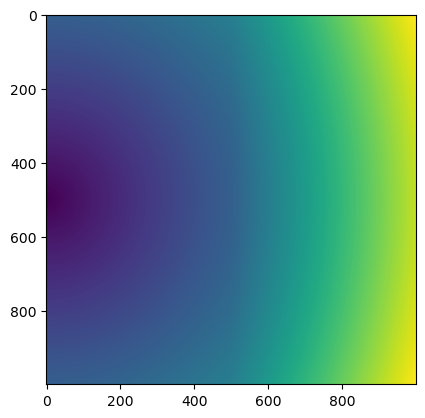

In [134]:
# !pip install scikit-fmm

import numpy as np
import skfmm
import matplotlib.pyplot as plt

def calcTimes(slow,src1,src2, ds):
    """
    slow - float array of slowness
    src1,src2 - Location of the source
    ds - sampling
    """
    
    phi=np.ones(ns)    # Create an array of 1s
    phi[src1,src2]=-1  # Set the source locationt
    return skfmm.travel_time(phi, slow, ds)  # calculate traveltimes


ns=[1000,1000]         # size of grid
div=int(ns[0]/2)       # middle of grid
slow=np.ndarray((ns))  # slowness
slow[:,:div]=1./2000   # top slowness
slow[:,div:]=1./4000   # bottom slowness
d=[5.,5.]              # grid spacing


tt=calcTimes(slow,div,0,d)  #calculate traveltimes

plt.imshow(tt)

What I would like to do is cacluate many travel time maps (don't execute the following cell because it will take a while but illustrates the point) and store it in an array.

In [148]:
def calcTimes(slow, isrc, ds, times):
    """
    slow - float array of slowness
    isr - Location of the source on the surface
    ds - sampling
    tt - Travel time
    """
    
    phi=np.ones(ns)      # Create an array of 1s
    phi[isrc, 0] = -1    # Set the source locationt
    times[isrc,:,:] = skfmm.travel_time(phi,slow,ds)  # Calculate traveltimes


Begin by using what you know about the pool function to create a parallel version of the above. Do not use above 4 threads because your are likely to run out of memory (and less if you run on your laptop) why?

**Response**: When using the Pool with multiple threads, the large array storing time table will be copied multiple times in the danger of running out of memory.

In [159]:
def calcTimes_ishot(slow, isrc, ds, times):
    """
    slow - float array of slowness
    isr - Location of the source on the surface
    ds - sampling
    tt - Travel time
    """
    
    phi=np.ones(ns)      # Create an array of 1s
    phi[isrc, 0] = -1    # Set the source locationt
    return skfmm.travel_time(phi,slow,ds)  # Calculate traveltimes


nthreads = 4
nsrc = 10

with multiprocess.Pool(nthreads) as pool:
    tts = [pool.apply(calcTimes_ishot, args=(slow, isrc, d, tt, )) for isrc in range(nsrc)]

tt = np.zeros((nsrc, slow.shape[0], slow.shape[0]))
for isrc, t in enumerate(tts):
    tt[isrc] = t

There are three challenges parallelizing the above.  The largest is the times array in which every thread is attempting to fill in different parts. What actually happened when you parallelized in the manner?

**Response**: After checking the memory profile during the runtime of the code above, I noticed that the big array storing the time table was copied 4 times when I used 4 threads.

The code you generated issue is that each spawned thread would make a pickled version of the slowness array. A third, more minor issue, is that the phi array is being reallocted 100 times in the above loop. Ideally it should be allocated once per thread, not once per job.

In Python, the multiprocessing module provides support for parallel execution of code using multiple processes. The RawArray class from this module can be used to create a shared memory array that can be accessed by multiple processes. This allows for efficient communication and data sharing between processes, as the data is stored in a shared memory segment that can be accessed directly by all processes, rather than being copied between them. This can be useful when working with large amounts of data or when performing computationally expensive operations that can be parallelized.

The following code shows how to create a raw array and wrap it into a numpy array.

In [ ]:
rawArray=multiprocess.RawArray("d",1000*1000)
numpyArray=np.frombuffer(rawArray).reshape(1000,1000)

If a rawArray is accessed by a thread the pickle function will not be called. You should be able to take advantageous of this fact to signficantly speed up.

You can also improve your code with the way you handle the phi variable.  Change your code to allocate phi as a 3-d array (nthreads,1000,1000) and use the multiprocess.current_process() function to index correctly into the array.

In [168]:
def calcTimes_new(phi, slow, isrc, ds, times):
    """
    slow - float array of slowness
    isr - Location of the source on the surface
    ds - sampling
    tt - Travel time
    """
    # get current index of process
    thrd = multiprocess.current_process()
    phi[thrd, isrc, 0] = -1  # Set the source locationt

    # calcualte time table
    return skfmm.travel_time(phi[thrd],slow,ds)  # calculate traveltimes


nsrc = 100
nthreads = 4

# rawArray = multiprocess.RawArray("d",1000*1000*nsrc)
# tt = np.frombuffer(rawArray).reshape(nsrc, 1000, 1000)
tts = []
with multiprocess.Pool(nthreads) as pool:
    for isrc in range(nsrc):
        phi = np.ones((nthreads,1000,1000))      # Create an 3D array of 1s
        tts.append(pool.apply(calcTimes_new, (phi, slow, isrc, d, tt, )))

        
tt = np.zeros((nsrc, slow.shape[0], slow.shape[0]))
for isrc, t in enumerate(tts):
    tt[isrc] = t
    
### Not correct

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

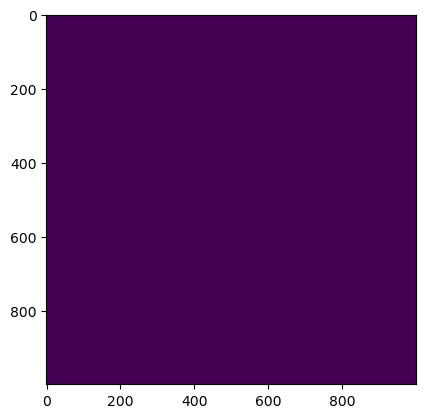

In [128]:
plt.imshow()

In [131]:
tt[1].min()

0.0